### Modelliamo l'andamento del titolo Google

Fonte: Lewinson 2020 Python for Finance Cookbook - cap. 3

In [1]:

from datetime import date, datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as scs
from TS_test_utils import test_autocorrelation


In [2]:
start_date = '2015-01-01'
end_date = '2018-12-31'

In [3]:
df = web.get_data_yahoo('GOOG', start_date, end_date) 

In [4]:
goog = df.resample('W').last().rename(columns={'Adj Close': 'adj_close'}).adj_close

In [5]:
goog_diff = goog.diff().dropna()

In [6]:
goog_diff

Date
2015-01-11   -28.561615
2015-01-18    11.877380
2015-01-25    31.782745
2015-02-01    -5.415100
2015-02-08    -3.510376
                ...    
2018-12-09   -57.850098
2018-12-16     5.520020
2018-12-23   -62.559998
2018-12-30    57.539978
2019-01-06    -1.469971
Freq: W-SUN, Name: adj_close, Length: 209, dtype: float64

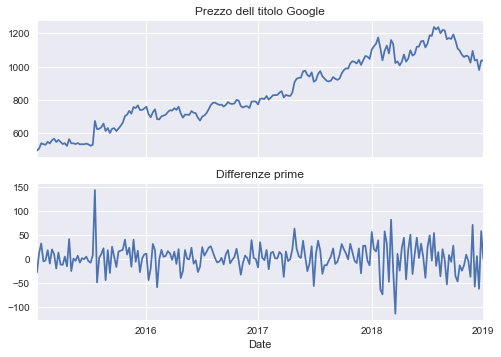

In [7]:
fig, ax = plt.subplots(2, sharex = True)
goog.plot(title = "Prezzo dell titolo Google", ax=ax[0])
goog_diff.plot(ax=ax[1], title='Differenze prime');

Testiamo la stazionarietà della serie differenziata

C:\Users\s.bencini\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)


ADF test statistic: -12.82 (p-val: 0.00)
KPSS test statistic: 0.11 (p-val: 0.10)


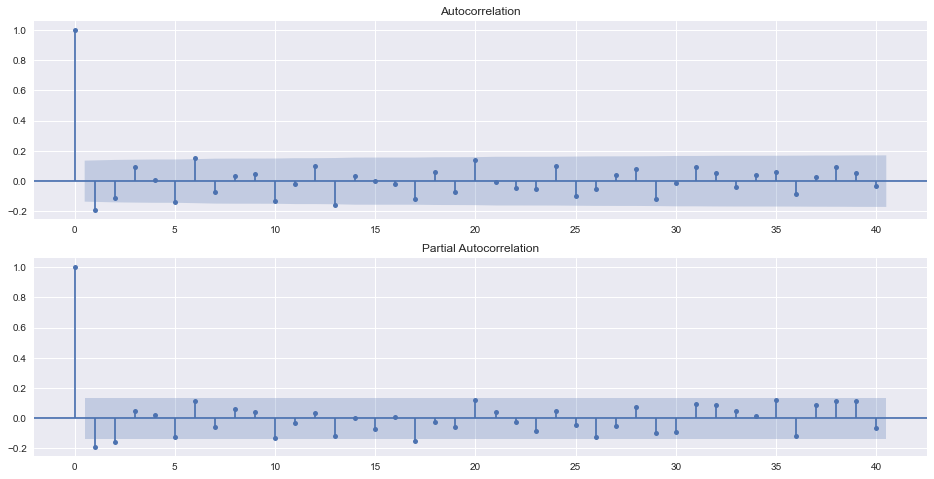

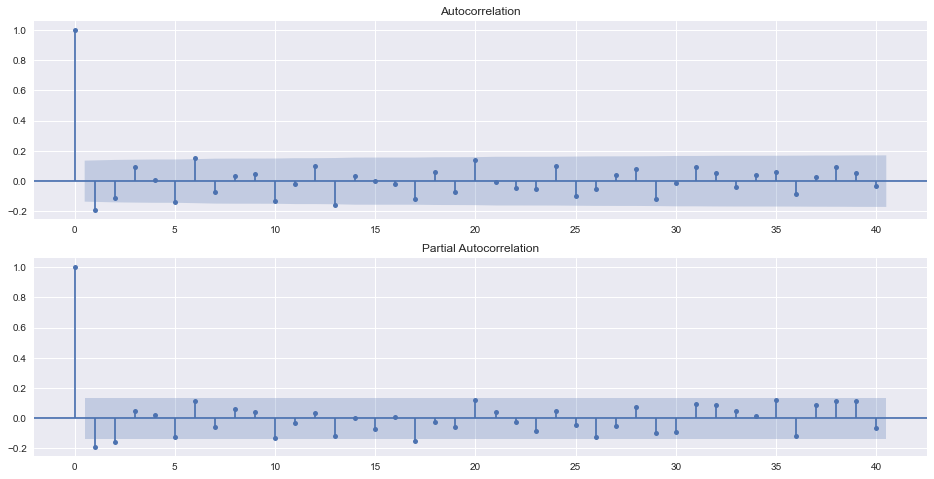

In [8]:
test_autocorrelation(goog_diff)

In statistica ed in econometria, il test KPSS (dal nome degli autori Kwiatkowski, Phillips, Schmidt e Shin) è un test di verifica d'ipotesi che si utilizza quando si vuole confrontare l'ipotesi nulla di stazionarietà di una serie storica autoregressiva con l'ipotesi alternativa che la serie abbia una (o più) radici unitarie.

Stimiamo il modello ARIMA

In [9]:
model = ARIMA(goog, order=(2,1,1))
arima = model.fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              adj_close   No. Observations:                  210
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -992.916
Date:                Mon, 13 Dec 2021   AIC                           1993.832
Time:                        17:04:38   BIC                           2007.201
Sample:                    01-04-2015   HQIC                          1999.237
                         - 01-06-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4065      0.394     -1.031      0.302      -1.179       0.366
ar.L2         -0.1835      0.081     -2.258      0.024      -0.343      -0.024
ma.L1          0.2055      0.402      0.511      0.609      -0.583       0.994
sigma2       783.1593     48.360     16.194      0.000     688.375     877.944
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               109.61
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.80   Skew:                             0.12
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Creiamo una funzione per la diagnostica del modello

In [10]:
def arima_diagnostics(resids, n_lags = 40):
    #localizziamo i quattro sotto grafici
    fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2,2)
    r =resids
    resids = (r - np.nanmean(r)) / np.nanstd(r)
    resids_nonmissing = resids[~(np.isnan(resids))]
    
    # grafico dei residui nel corso del tempo
    sns.lineplot(x=np.arange(len(resids))[1:], y= resids[1:], ax=ax1)
    ax1.set_title('Residui standardizzati')
    
    # distribuzione dei residui
    x_lim = (-1.96 * 2, 1.96 * 2)
    r_range = np.linspace(x_lim[0], x_lim[1])
    norm_pdf = scs.norm.pdf(r_range)
    sns.distplot(resids_nonmissing, hist = True, kde = True,
                norm_hist = True, ax = ax2)
    ax2.plot(r_range, norm_pdf, 'g', lw = 2, label='N(0,1)')
    ax2.set_title('Distribuzione dei rensidui standardizzati')
    ax2.set_xlim(x_lim)
    ax2.legend()
    
    # Grafico Quantili - Quantili (Q-Q) 
    qq = sm.qqplot(resids_nonmissing[1:], line = 's', ax = ax3)
    ax3.set_title('Grafico Q-Q')
    
    # Grafico ACF
    plot_acf(resids[1:], ax=ax4, lags=n_lags, alpha=0.05)
    ax4.set_title('Grafico ACF')
    
    return fig
    

C:\Users\s.bencini\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


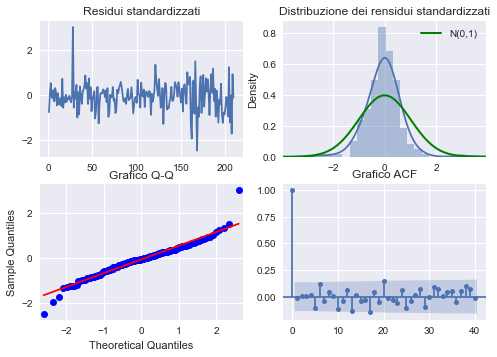

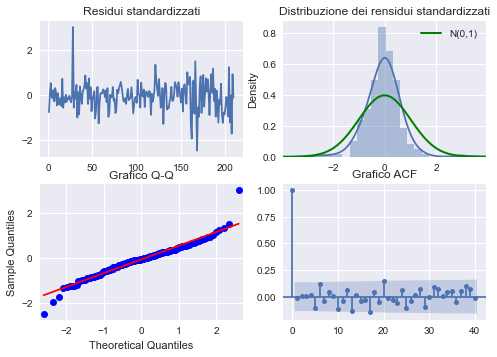

In [11]:
arima_diagnostics(arima.resid, 40)

C:\Users\s.bencini\Anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:531: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  warnings.warn("The default value of lags is changing.  After 0.12, "
C:\Users\s.bencini\Anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Test di Ljung-Box - Risultati'),
 Text(0.5, 0, 'Lag'),
 Text(0, 0.5, 'p-values')]

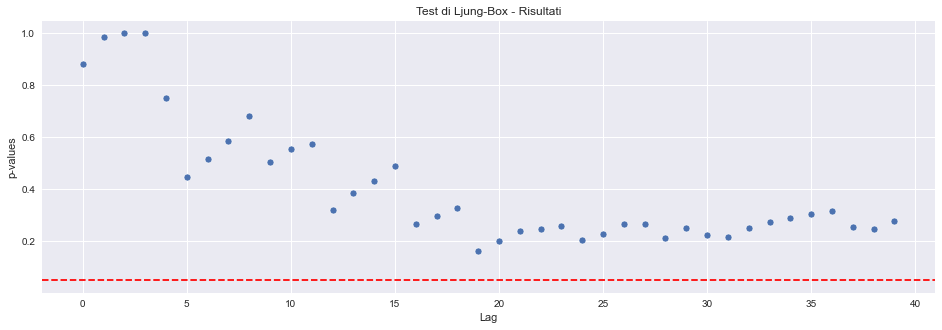

In [12]:
ljung_box_results = acorr_ljungbox(arima.resid[1:])
fig, ax = plt.subplots(1, figsize=(16,5))
sns.scatterplot(x=range(len(ljung_box_results[1])),
                y=ljung_box_results[1],
                ax=ax)
ax.axhline(0.05, ls = '--', c = 'r')
ax.set(title='Test di Ljung-Box - Risultati', xlabel='Lag', ylabel='p-values')
                                
                                   


#### Stima automatica dei parametri del modello ARIMA

In [13]:
import pmdarima as pm

In [14]:
model = pm.auto_arima(goog, error_action='ignore', suppress_warnings = True,
                     seasonal=False)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  210
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -993.016
Date:                Mon, 13 Dec 2021   AIC                           1992.033
Time:                        17:04:44   BIC                           2002.060
Sample:                             0   HQIC                          1996.087
                                - 210                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.4804      1.483      1.672      0.094      -0.427       5.388
ma.L1         -0.2368      0.069     -3.427      0.001      -0.372      -0.101
sigma2       783.3344     44.532     17.590      0.000     696.054     870.615
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               133.60
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                             0.05
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Il modello trovato è quello chiamato SES, Simple Exponential Smoothing

Cerchiamo i parametri ottimali

In [15]:
auto_arima = pm.auto_arima(goog, error_action='ignore', suppress_warnings = True,
                     seasonal=False, stepwise = False, approximation = False,
                     n_jobs = -1)
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  210
Model:               SARIMAX(3, 1, 2)   Log Likelihood                -986.980
Date:                Mon, 13 Dec 2021   AIC                           1987.961
Time:                        17:04:51   BIC                           2011.357
Sample:                             0   HQIC                          1997.420
                                - 210                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     10.0741      6.221      1.619      0.105      -2.119      22.267
ar.L1         -1.5420      0.137    -11.234      0.000      -1.811      -1.273
ar.L2         -1.1798      0.137     -8.608      0.000      -1.448      -0.911
ar.L3         -0.3005      0.067     -4.489      0.000      -0.432      -0.169
ma.L1          1.3600      0.140      9.738      0.000       1.086       1.634
ma.L2          0.7916      0.132      5.994      0.000       0.533       1.050
sigma2       738.6902     49.968     14.783      0.000     640.755     836.625
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               119.91
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.81   Skew:                             0.09
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Previsione con ARIMA

In [16]:
start_date = '2019-01-01'
end_date = '2019-03-31'

In [17]:
df = web.get_data_yahoo('GOOG', start_date, end_date) 

In [18]:
test = df.resample('W') \
         .last() \
         .rename(columns={'Adj Close': 'adj_close'}) \
         .adj_close 

In [27]:
n_forecasts = len(test)

arima_pred = arima.forecast(n_forecasts)

#arima_pred = pd.DataFrame(arima_pred, columns=['prediction'])
#arima_pred = pd.DataFrame(arima_pred).set_index(test.index)

#pd.DataFrame(arima_pred[2], columns=['ci_lower', 'ci_upper'])]
#arima_pred = pd.concat(arima_pred, axis=1).set_index(test.index)

In [28]:
arima_pred

,prediction


#### Previsione con AUTO-ARIMA

In [21]:
auto_arima_pred = auto_arima.predict(n_periods=n_forecasts, 
                                     return_conf_int=True, 
                                     alpha=0.05)

auto_arima_pred = [pd.DataFrame(auto_arima_pred[0], 
                                columns=['prediction']),
                   pd.DataFrame(auto_arima_pred[1], 
                                columns=['ci_lower', 'ci_upper'])]
auto_arima_pred = pd.concat(auto_arima_pred, 
                            axis=1).set_index(test.index)

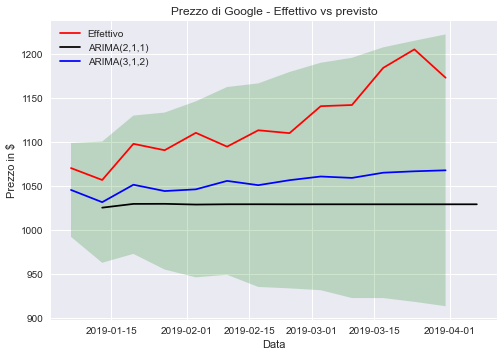

In [22]:
fig, ax = plt.subplots(1)
ax = sns.lineplot(data=test, color = 'r', label ='Effettivo')
ax.plot(arima_pred, color ='k', label = 'ARIMA(2,1,1)')
ax.plot(auto_arima_pred.prediction, color = 'b', label='ARIMA(3,1,2)')
ax.fill_between(auto_arima_pred.index,
               auto_arima_pred.ci_lower,
               auto_arima_pred.ci_upper,
               alpha = 0.2,
               facecolor = 'g')

ax.set(title='Prezzo di Google - Effettivo vs previsto',
      xlabel = 'Data',
      ylabel = 'Prezzo in $')
ax.legend(loc='upper left');